In [1]:
!date

Fri May 17 00:21:00 PDT 2019


# Figure 3

We are using the fastqs made from the BAM file of SRR6470906 and SRR6470907

In [17]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy as scp
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import sys
import loompy
import scipy.optimize
import velocyto as vcy
import scvelo as scv
import glob
import pickle
import anndata

from collections import Counter
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import reference matrices

In [26]:
them = scv.read('data/ForebrainGlut/hgForebrainGlut.loom', cleanup=True, sparse=True, cache=True, backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
them.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Import spliced and unspliced matrices from the kallisto workflow

In [4]:
%%time
spliced06 = "/home/sina/projects/bus/velocity/bus_out/human_embryo_forebrain/SRR6470906/gene_count/gc_cDNA/"
unspliced06 = "/home/sina/projects/bus/velocity/bus_out/human_embryo_forebrain/SRR6470906/gene_count/gc_introns/"

s06 = sc.read_mtx(spliced06 + "s.mtx")
u06 = sc.read_mtx(unspliced06 + "u.mtx")

s_bcs06 = pd.read_csv(spliced06 + "s.barcodes.txt", header=None)
u_bcs06 = pd.read_csv(unspliced06 + "u.barcodes.txt", header=None)

s_genes06 = pd.read_csv(spliced06 + "s.genes.txt", header=None)
u_genes06 = pd.read_csv(unspliced06 + "u.genes.txt", header=None)

s06.obs.index = s_bcs06[0].values
u06.obs.index = u_bcs06[0].values

s06.var.index = s_genes06[0].values
u06.var.index = u_genes06[0].values

# del s_bcs06
# del u_bcs06
# del s_genes06
# del u_genes06

CPU times: user 38.1 s, sys: 823 ms, total: 38.9 s
Wall time: 38.8 s


In [5]:
%%time
spliced07 = "/home/sina/projects/bus/velocity/bus_out/human_embryo_forebrain/SRR6470907/gene_count/gc_cDNA/"
unspliced07 = "/home/sina/projects/bus/velocity/bus_out/human_embryo_forebrain/SRR6470907/gene_count/gc_introns/"

s07 = sc.read_mtx(spliced07 + "s.mtx")
u07 = sc.read_mtx(unspliced07 + "u.mtx")

s_bcs07 = pd.read_csv(spliced07 + "s.barcodes.txt", header=None)
u_bcs07 = pd.read_csv(unspliced07 + "u.barcodes.txt", header=None)

s_genes07 = pd.read_csv(spliced07 + "s.genes.txt", header=None)
u_genes07 = pd.read_csv(unspliced07 + "u.genes.txt", header=None)

s07.obs.index = s_bcs07[0].values
u07.obs.index = u_bcs07[0].values

s07.var.index = s_genes07[0].values
u07.var.index = u_genes07[0].values

# del s_bcs07
# del u_bcs07
# del s_genes07
# del u_genes07

CPU times: user 50.3 s, sys: 1.09 s, total: 51.4 s
Wall time: 51.2 s


In [6]:
s = scp.sparse.vstack([s06.X, s07.X])
u = scp.sparse.vstack([u06.X, u07.X])

In [7]:
s_bcs06["sample"] = "06"
s_bcs07["sample"] = "07"

u_bcs06["sample"] = "06"
u_bcs07["sample"] = "07"

In [8]:
s_bcs06.columns = ["bcs", "sample"]
s_bcs07.columns = ["bcs", "sample"]

u_bcs06.columns = ["bcs", "sample"]
u_bcs07.columns = ["bcs", "sample"]

In [9]:
s_bcs06.index = s_bcs06["bcs"] + "." + s_bcs06["sample"]
s_bcs07.index = s_bcs07["bcs"] + "." + s_bcs07["sample"]

u_bcs06.index = u_bcs06["bcs"] + "." + u_bcs06["sample"]
u_bcs07.index = u_bcs07["bcs"] + "." + u_bcs07["sample"]

In [10]:
s_bcs = pd.concat([s_bcs06, s_bcs07],ignore_index=False)
u_bcs = pd.concat([u_bcs06, u_bcs07],ignore_index=False)

In [11]:
genes = s_genes06
genes.columns=["gid"]

In [28]:
sadata = anndata.AnnData(X=s, obs=s_bcs, var=genes)
uadata = anndata.AnnData(X=u, obs=u_bcs, var=genes)

In [29]:
print(sadata)
print(uadata)

AnnData object with n_obs × n_vars = 588330 × 64792 
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 395178 × 64792 
    obs: 'bcs', 'sample'
    var: 'gid'


In [14]:
t2g = pd.read_csv("/home/sina/projects/bus/velocity/index/human/gencodeV29/90/make_fasta/human.gencodeV29.t2g.no_version.txt", header=None, sep="\t", names=["tid", "gid", "gene"])
t2g = t2g.drop_duplicates(["gid", "gene"])
t2g = t2g.set_index("gid")

In [15]:
#them.obs.index = them.obs.index.str.slice(11,-1)

In [30]:
them.obs["bcs"] = them.obs.index.str.slice(11,-1)

28 <-> 07, 29 <-> 06

In [31]:
them.obs["bid"] = them.obs.index.str.slice(8,10)

In [32]:
them.obs["sample"] = them.obs.bid.map(lambda x: "06" if x=="29" else "07")

In [33]:
them.obs.head()

,Clusters,bcs,bid,sample
index,,,,
10X_17_028:AACCATGGTAATCACCx,3,AACCATGGTAATCACC,28,07
10X_17_028:AACCATGCATACTACGx,3,AACCATGCATACTACG,28,07
10X_17_028:AAACCTGGTAAAGGAGx,1,AAACCTGGTAAAGGAG,28,07
10X_17_028:AAAGTAGCAAAGTCAAx,0,AAAGTAGCAAAGTCAA,28,07
10X_17_028:AAAGCAACAAACGCGAx,3,AAAGCAACAAACGCGA,28,07


In [34]:
them.obs.index = them.obs.bcs.values + "."+ them.obs["sample"]

In [35]:
print(sadata)
print(uadata)
print(them)

AnnData object with n_obs × n_vars = 588330 × 64792 
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 395178 × 64792 
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 1720 × 32738 
    obs: 'Clusters', 'bcs', 'bid', 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'


## Select the barcodes/genes for s and u by those in them

In [36]:
sadata = sadata[sadata.obs.index.isin(them.obs.index),:]
uadata = uadata[uadata.obs.index.isin(them.obs.index),:]
sadata = sadata[:,sadata.var.gid.isin(them.var.Accession)]
uadata = uadata[:,uadata.var.gid.isin(them.var.Accession)]

In [37]:
print(sadata)
print(uadata)
print(them)

View of AnnData object with n_obs × n_vars = 1720 × 31114 
    obs: 'bcs', 'sample'
    var: 'gid'
View of AnnData object with n_obs × n_vars = 1720 × 31114 
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 1720 × 32738 
    obs: 'Clusters', 'bcs', 'bid', 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'


In [38]:
sadata = sadata[sadata.obs.index.isin(uadata.obs.index),:]
uadata = uadata[uadata.obs.index.isin(sadata.obs.index),:]

In [39]:
print(sadata)
print(uadata)
print(them)

View of AnnData object with n_obs × n_vars = 1720 × 31114 
    obs: 'bcs', 'sample'
    var: 'gid'
View of AnnData object with n_obs × n_vars = 1720 × 31114 
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 1720 × 32738 
    obs: 'Clusters', 'bcs', 'bid', 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'


## Make annotated dataframe for the kallisto matrices
This involves making a blank ambiguous matrix (since the current implementation of kallisto does not produce an ambiguous matrix), transferring the cluster IDs, and formatting the adata so that the velocyto jupyter notebook can process it.

In [42]:
%%time
adata = sadata.copy()

adata.layers["spliced"] = sadata.X
adata.layers["unspliced"] = uadata.X
adata.layers["ambiguous"] = scp.sparse.csr_matrix(np.zeros(adata.X.shape))

adata.obs = sadata.obs
adata.var.index = sadata.var.gid

adata.obs["CellID"] = adata.obs.index
adata.obs["Clusters"] = adata.obs.index.map(them.obs["Clusters"])
adata.var["Gene"] = adata.var.index.map(t2g["gene"])
adata.var["Accession"] = adata.var.index
adata.var = adata.var.set_index("Gene")

CPU times: user 584 ms, sys: 3.88 ms, total: 588 ms
Wall time: 586 ms


In [45]:
adata.obs.head()

,bcs,sample,CellID,Clusters
AAACGGGAGATTACCC.06,AAACGGGAGATTACCC,06,AAACGGGAGATTACCC.06,6
AAACGGGTCGCTAGCG.06,AAACGGGTCGCTAGCG,06,AAACGGGTCGCTAGCG.06,5
AAATGCCTCTAACTCT.06,AAATGCCTCTAACTCT,06,AAATGCCTCTAACTCT.06,4
AACACGTAGGTAGCCA.06,AACACGTAGGTAGCCA,06,AACACGTAGGTAGCCA.06,5
AACACGTCATTACGAC.06,AACACGTCATTACGAC,06,AACACGTCATTACGAC.06,5


In [46]:
scv.pp.show_proportions(adata)
print(adata)

Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.55 0.45 0.  ]
AnnData object with n_obs × n_vars = 1720 × 31114 
    obs: 'bcs', 'sample', 'CellID', 'Clusters'
    var: 'gid', 'Accession'
    layers: 'spliced', 'unspliced', 'ambiguous'


## Save the adata as a loom file so it can be ran in the Veloctyo Python pipeline

In [47]:
adata.write_loom("./test_kallisto.loom")

# Run the Velocyto Python pipeline

In [48]:
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

## These are helper functions

In [68]:
# Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve", on_conflict="warn")
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

In [69]:
princurve = importr("princurve", on_conflict="warn")

/home/sina/tools/miniconda/lib/python3.7/site-packages/rpy2/robjects/packages_utils.py:111: UserWarning: Conflict when converting R symbols in the package "princurve" to Python symbols: 
-lines_principal_curve -> lines.principal_curve, lines.principal.curve
- plot_principal_curve -> plot.principal_curve, plot.principal.curve
- points_principal_curve -> points.principal_curve, points.principal.curve
  warn(msg)


## Load the loom file

In [57]:
vlm = vcy.VelocytoLoom("./test_kallisto.loom")

In [58]:
# Load an initial clustering (Louvein)
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

## Velocity Analysis

In [59]:
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

In [60]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

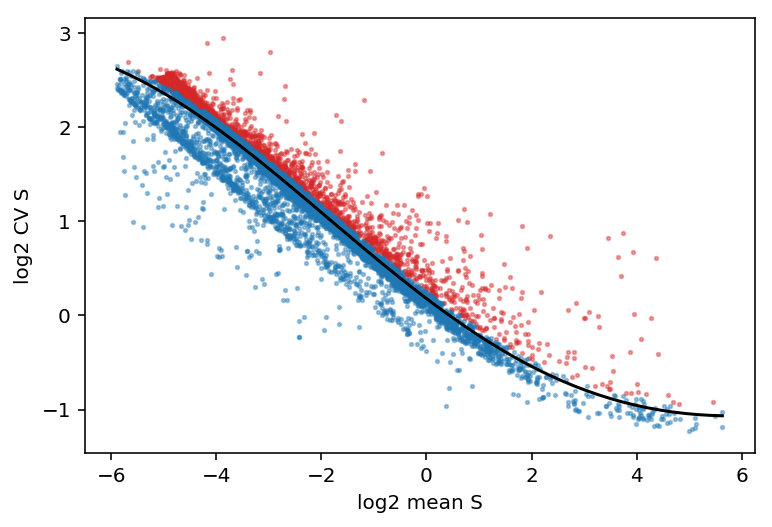

In [61]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [62]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

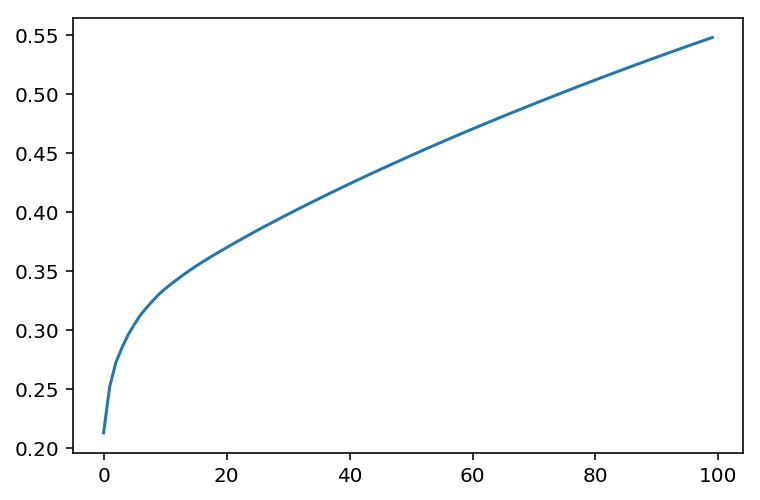

In [63]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 # flip for consistency with previous version

In [64]:
from sklearn.neighbors import NearestNeighbors
import igraph
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [65]:
from numpy_groupies import aggregate, aggregate_np

In [70]:
pc_obj = principal_curve(vlm.pcs[:,:4], False)
pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength
labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]

/home/sina/tools/miniconda/lib/python3.7/site-packages/rpy2/robjects/packages_utils.py:111: UserWarning: Conflict when converting R symbols in the package "princurve" to Python symbols: 
-lines_principal_curve -> lines.principal_curve, lines.principal.curve
- plot_principal_curve -> plot.principal_curve, plot.principal.curve
- points_principal_curve -> points.principal_curve, points.principal.curve
  warn(msg)


In [71]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [72]:
k = 550
vlm.knn_imputation(n_pca_dims=n_comps,k=k)

In [73]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [74]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

In [75]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

In [76]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

In [77]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

In [78]:
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

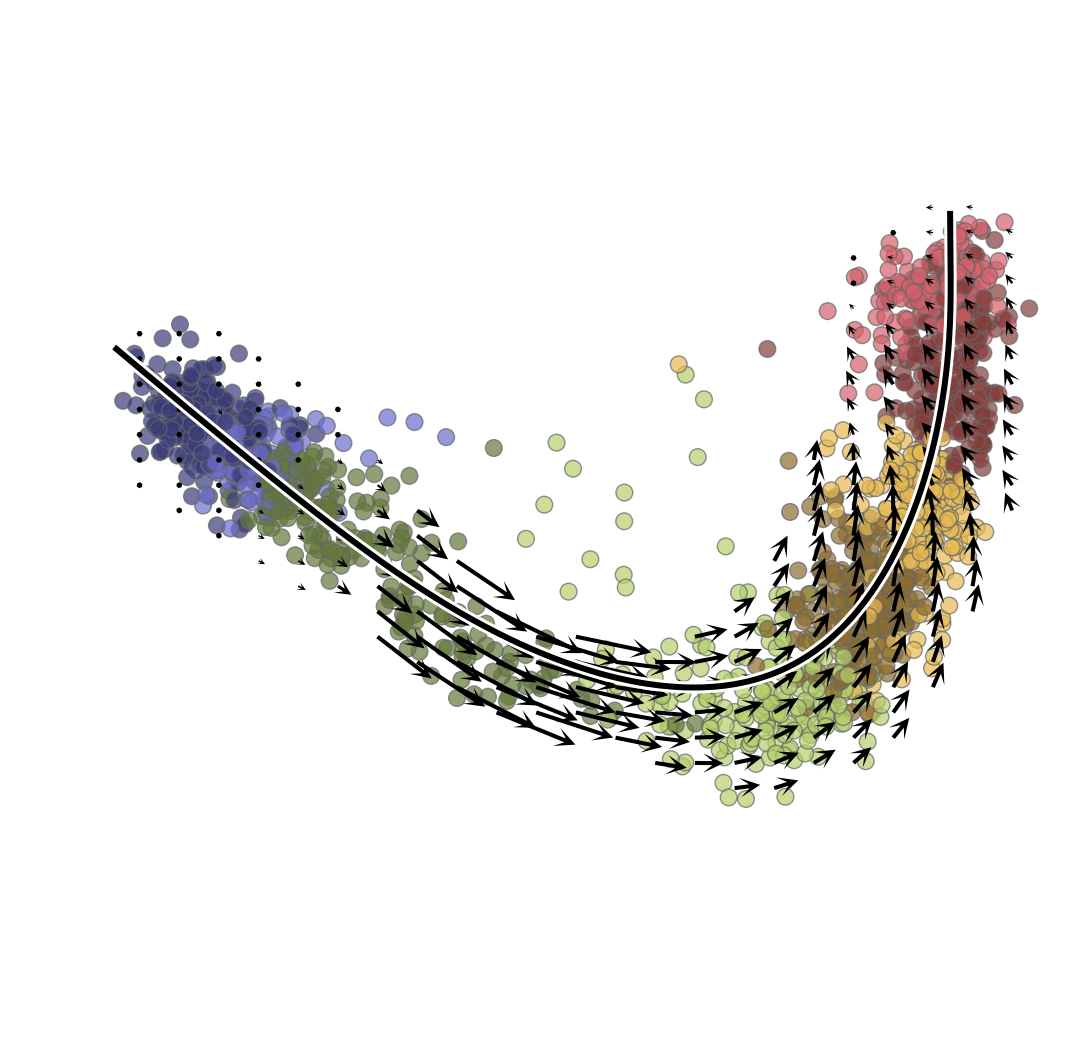

In [79]:
plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");
plt.savefig("kallisto_velocity_forebrain_glut.pdf")

## Plot level of expression by max proj

In [80]:
ds = loompy.connect("test_kallisto.loom")

In [81]:
from matplotlib.colors import LinearSegmentedColormap
def scatter_lev(x, y, score, *args, **kwargs):
    ix_x_sort = np.argsort(score, kind="mergesort")
    ix_yx_sort = ix_x_sort
    args_new = []
    kwargs_new = {}
    for arg in args:
        if type(arg) is np.ndarray:
            args_new.append(arg[ix_x_sort][ix_yx_sort])
        else:
            args_new.append(arg)
    for karg, varg in kwargs.items():
        if type(varg) is np.ndarray:
            kwargs_new[karg] = varg[ix_x_sort][ix_yx_sort]
        else:
            kwargs_new[karg] = varg
    ax = plt.scatter(x[ix_x_sort][ix_yx_sort], y[ix_x_sort][ix_yx_sort], *args_new, **kwargs_new)
    return ax

/home/sina/tools/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/sina/tools/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/home/sina/tools/miniconda/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


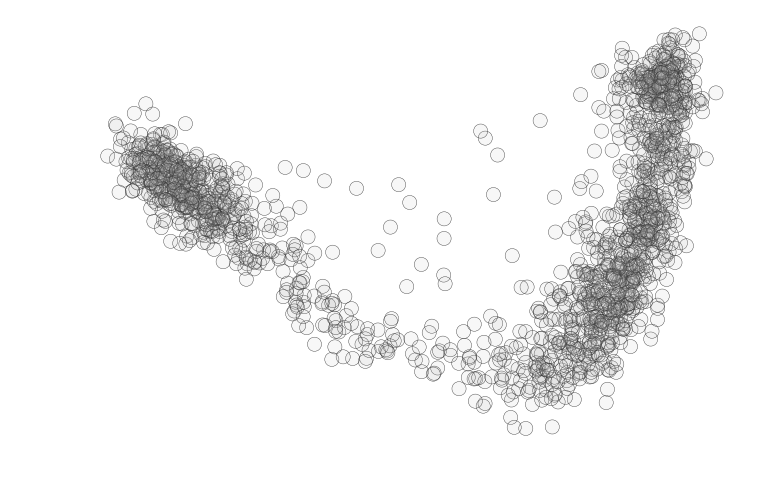

In [82]:
#list_genes = np.array(["SOX2", "EOMES", "SLC17A7"])
list_genes = np.array(["ENSG00000181449", "ENSG00000163508", "ENSG00000104888"])
list_colors = [[104,254,246,255], [251,243,66,255], [203,38,229,255]]
list_colors = np.array([np.array(i)/255 for i in list_colors])

# Extract level of expression
list_xs = []
list_s = []
for gene in list_genes:
    x = ds.layer["spliced"][np.where(ds.row_attrs["Accession"][:] == gene)[0][0], :]
    x = np.mean(vlm.initial_cell_size) * x / vlm.initial_cell_size
    list_s.append(x)
list_s = np.array(list_s)
scal_s = list_s / np.percentile(list_s, 98, 1)[:,None]
max_s = np.argmax(scal_s, 0)

# Make color Array
clarr = np.zeros((max_s.shape[0], 4))
clscore= np.zeros((max_s.shape[0]))
for i in range(len(list_genes)):
    base = (list_colors[i] + np.array([0.6,0.6,0.6, 0.3])) / 2.
    color_gene = LinearSegmentedColormap.from_list(f"color_{list_genes[i]}" , [base, list_colors[i]], )
    sel = (max_s==i) & (scal_s[i] > 0.45)
    clarr[(max_s==i), :] = np.array([0.7,0.7,0.7, 0.1])
    clarr[sel, :] = color_gene(np.log(scal_s[i]+1))[sel]
    clscore[sel] = np.log(scal_s[i]+1)[sel]
    
scatter_lev(-vlm.pcs[:,0], vlm.pcs[:,1], score=clarr[:,-1], c=clarr, s=50, lw=0.2, edgecolor="0.2", rasterized=True)

plt.axis("off");

# Plot different dynamics

Filter genes that peak at the different timepoints removing the ones that show low correlation between velocity and expression

In [83]:
segments = np.linspace(0, np.max(pc_obj.arclength),10)
fragments = -np.ones(pc_obj.arclength.shape, dtype=int)
for i in range(len(segments)-1):
    fragments[(pc_obj.arclength > segments[i]) & (pc_obj.arclength <= segments[i+1])] = i
    
medial_fragments = -np.ones(pc_obj.arclength.shape, dtype=int)
for i in range(len(segments)-2):
    medial_fragments[(pc_obj.arclength > segments[i:i+2].mean()) & (pc_obj.arclength < segments[i+1:i+3].mean())] = i
    
s = aggregate(fragments[fragments>=0], vlm.Sx_sz[:, fragments>=0], func="mean", axis=1)
u = aggregate(fragments[fragments>=0], vlm.Ux_sz[:, fragments>=0], func="mean", axis=1)
v = aggregate(medial_fragments[medial_fragments>=0], vlm.Sx_sz_t[:, medial_fragments>=0] - vlm.Sx_sz[:, medial_fragments>=0], func="mean", axis=1)

In [84]:
# Enrichment score by pseutotime
n_cells = vlm.cluster_ix.shape[0]

# Number of cells per cluster
sizes = np.bincount(vlm.cluster_ix)
# Number of nonzero values per cluster
nnz = aggregate(vlm.cluster_ix, (vlm.Sx_sz>0).astype(float), func="sum", axis=1)
# Mean value per cluster
means = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)
# Non-zeros and means over all cells
nnz_overall, means_overall = (vlm.Sx_sz>0).sum(1), vlm.Sx_sz.mean(1)
# Scale by number of cells
f_nnz = nnz / sizes
f_nnz_overall = nnz_overall / n_cells

# Means and fraction non-zero values in other clusters (per cluster)
means_other = ((means_overall * n_cells)[None].T - (means * sizes)) / (n_cells - sizes)
f_nnz_other = ((f_nnz_overall * n_cells)[None].T - (f_nnz * sizes)) / (n_cells - sizes)

enrichment = (f_nnz + 0.1) / (f_nnz_overall[None].T + 0.1) * (means + 0.01) / (means_overall[None].T + 0.01)

In [85]:
#List of top eneriched genes
list_enriched = []
score_enriched = []
for i in range(enrichment.shape[1]):
    score_enriched.append(enrichment[:,i][np.argsort(enrichment[:,i])[::-1]][:350])
    list_enriched.append(vlm.ra["Accession"][np.argsort(enrichment[:,i])[::-1]][:350])

In [86]:
def clean_duplicates(list_enriched, score_enriched):
    for i in range(len(list_enriched)):
        current_ = list_enriched[i]
        for j in range(len(current_)):
            gj = current_[j]
            for n in range(len(list_enriched[i+1:])):
                if gj in list_enriched[n+i+1] and gj != "":
                    if score_enriched[n+i+1][np.where(list_enriched[n+i+1]==gj)[0][0]] > score_enriched[i][j]:
                        list_enriched[i][j] = ""
                    else:
                        list_enriched[n+i+1][np.where(list_enriched[n+i+1]==gj)[0][0]] = ""
    for i in range(enrichment.shape[1]):
        list_enriched[i] = list_enriched[i][list_enriched[i] != ""]
    return list_enriched

def paired_correlations(X, Y):
    Xm = X - X.mean(0)
    Ym = Y - Y.mean(0)
    return (Xm * Ym).sum(0) / (np.linalg.norm(Xm,2,0) * np.linalg.norm(Ym,2,0))

In [87]:
Cc = paired_correlations((s[:,1:] - s[:,:-1]).T, v.T)

In [88]:
for i in range(enrichment.shape[1]):
    selection_bool = np.in1d(list_enriched[i], vlm.ra["Accession"][Cc>0.55])
    score_enriched[i] = score_enriched[i][selection_bool][:120]
    list_enriched[i] = list_enriched[i][selection_bool][:120]

In [89]:
list_enriched = clean_duplicates(list_enriched, score_enriched)

selected_genes_n = int(np.mean([len(list_enriched[i]) for i in range(len(list_enriched))]))
for i in range(enrichment.shape[1]):
    list_enriched[i] = list_enriched[i][:selected_genes_n]
list_enriched_flat = np.hstack(list_enriched)

list_enriched_flat_new = []
for i in list_enriched_flat:
    if i not in list_enriched_flat_new:
        list_enriched_flat_new.append(i)
list_enriched_flat= np.array(list_enriched_flat_new)

In [90]:
s = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)
u = aggregate(vlm.cluster_ix, vlm.Ux_sz, func="mean", axis=1)

ix_filter = np.where(np.in1d(vlm.ra["Accession"], list_enriched_flat))[0]
gene_filtered = vlm.ra["Accession"][ix_filter]

Ssort = s[ix_filter,:] / s[ix_filter,:].sum(1)[:,None]
Usort = u[ix_filter,:] / u[ix_filter,:].sum(1)[:,None]
ix1 = np.argsort(Usort.argmax(1), kind='mergesort')
ix2 = np.argsort(Ssort[ix1, :].argmax(1), kind='mergesort')
ixa2b = ix1[ix2]

In [91]:
ra_gene = np.array(vlm.ra["Accession"])[ix_filter][ixa2b]
gammas = np.array(vlm.gammas)[ix_filter][ixa2b]

S = s[ix_filter,:][ixa2b,:]
S_norm = np.array(S) - np.percentile(S, 1,1)[:,None]
S_norm = S_norm / np.percentile(S_norm, 99,1)[:,None]
S_norm = np.clip(S_norm, 0,1)

U = u[ix_filter,:][ixa2b,:]
U_norm = np.array(U) - np.percentile(U, 1,1)[:,None]
U_norm = U_norm / np.percentile(U_norm, 99,1)[:,None]
U_norm = np.clip(U_norm, 0,1)

In [92]:
from matplotlib import colors

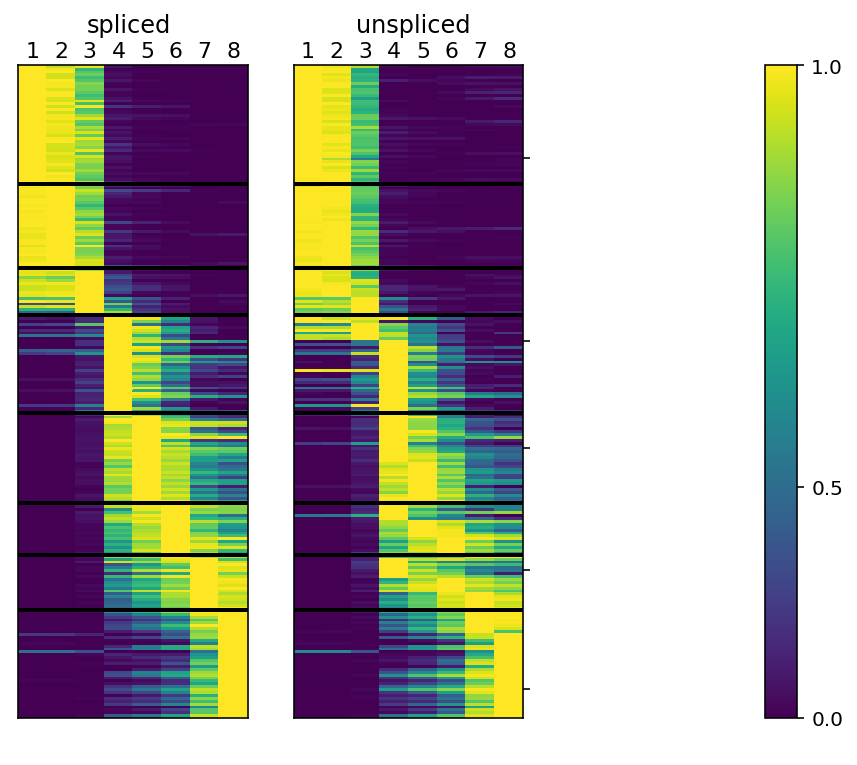

In [93]:
plt.figure(None, (7, 6))
plt.subplot(131)
plt.text(0.3,1.05,"spliced", fontdict={"size":12}, transform=plt.gca().transAxes )
plt.xticks(np.arange(s.shape[1])+0.5, np.arange(s.shape[1])+1, fontsize=11, ha="center", va="center");
plt.gca().tick_params(axis='x', labeltop=True, labelbottom=False, bottom=False )
plt.gca().tick_params(axis='y', labelleft=False, left=False )


plt.pcolormesh(S_norm, cmap=plt.cm.viridis, norm=colors.PowerNorm(gamma=1.5)) # aspect=0.1, interpolation="none"
plt.gca().invert_yaxis()
for hl in np.where(np.diff(Ssort[ixa2b, :].argmax(1)))[0]:
    plt.axhline(hl, c="k", lw=2)
    
plt.subplot(132)
plt.text(0.27,1.05,"unspliced", fontdict={"size":12}, transform=plt.gca().transAxes )
plt.xticks(np.arange(s.shape[1])+0.5, np.arange(s.shape[1])+1, fontsize=11, ha="center", va="center");
plt.gca().tick_params(axis='x', labeltop=True, labelbottom=False, bottom=False )
plt.gca().tick_params(axis='y', labelleft=False, left=False )


cax = plt.pcolormesh(U_norm, cmap=plt.cm.viridis,norm=colors.PowerNorm(gamma=1.5),) #aspect=0.1, interpolation="none",   
plt.gca().invert_yaxis()

for hl in np.where(np.diff(Ssort[ixa2b, :].argmax(1)))[0]:
    plt.axhline(hl, c="k", lw=2)

plt.gca().tick_params(axis='y', labelleft=False, left=False, right=True)
plot_these = ["ENSG00000129195", "ENSG00000136104", "ENSG00000162374", "ENSG00000077279", "ENSG00000104435", "ENSG00000125675"]
old = ["FAM64A", "RNASEH2B", "ELAVL4", "DCX", "STMN2", "GRIA3"]
plt.yticks(np.where(np.in1d(ra_gene, plot_these))[0])

plt.subplot(133)
plt.axis("off")
plt.colorbar(cax, ax=plt.gca(),ticks=[0,0.5,1.], orientation='vertical')

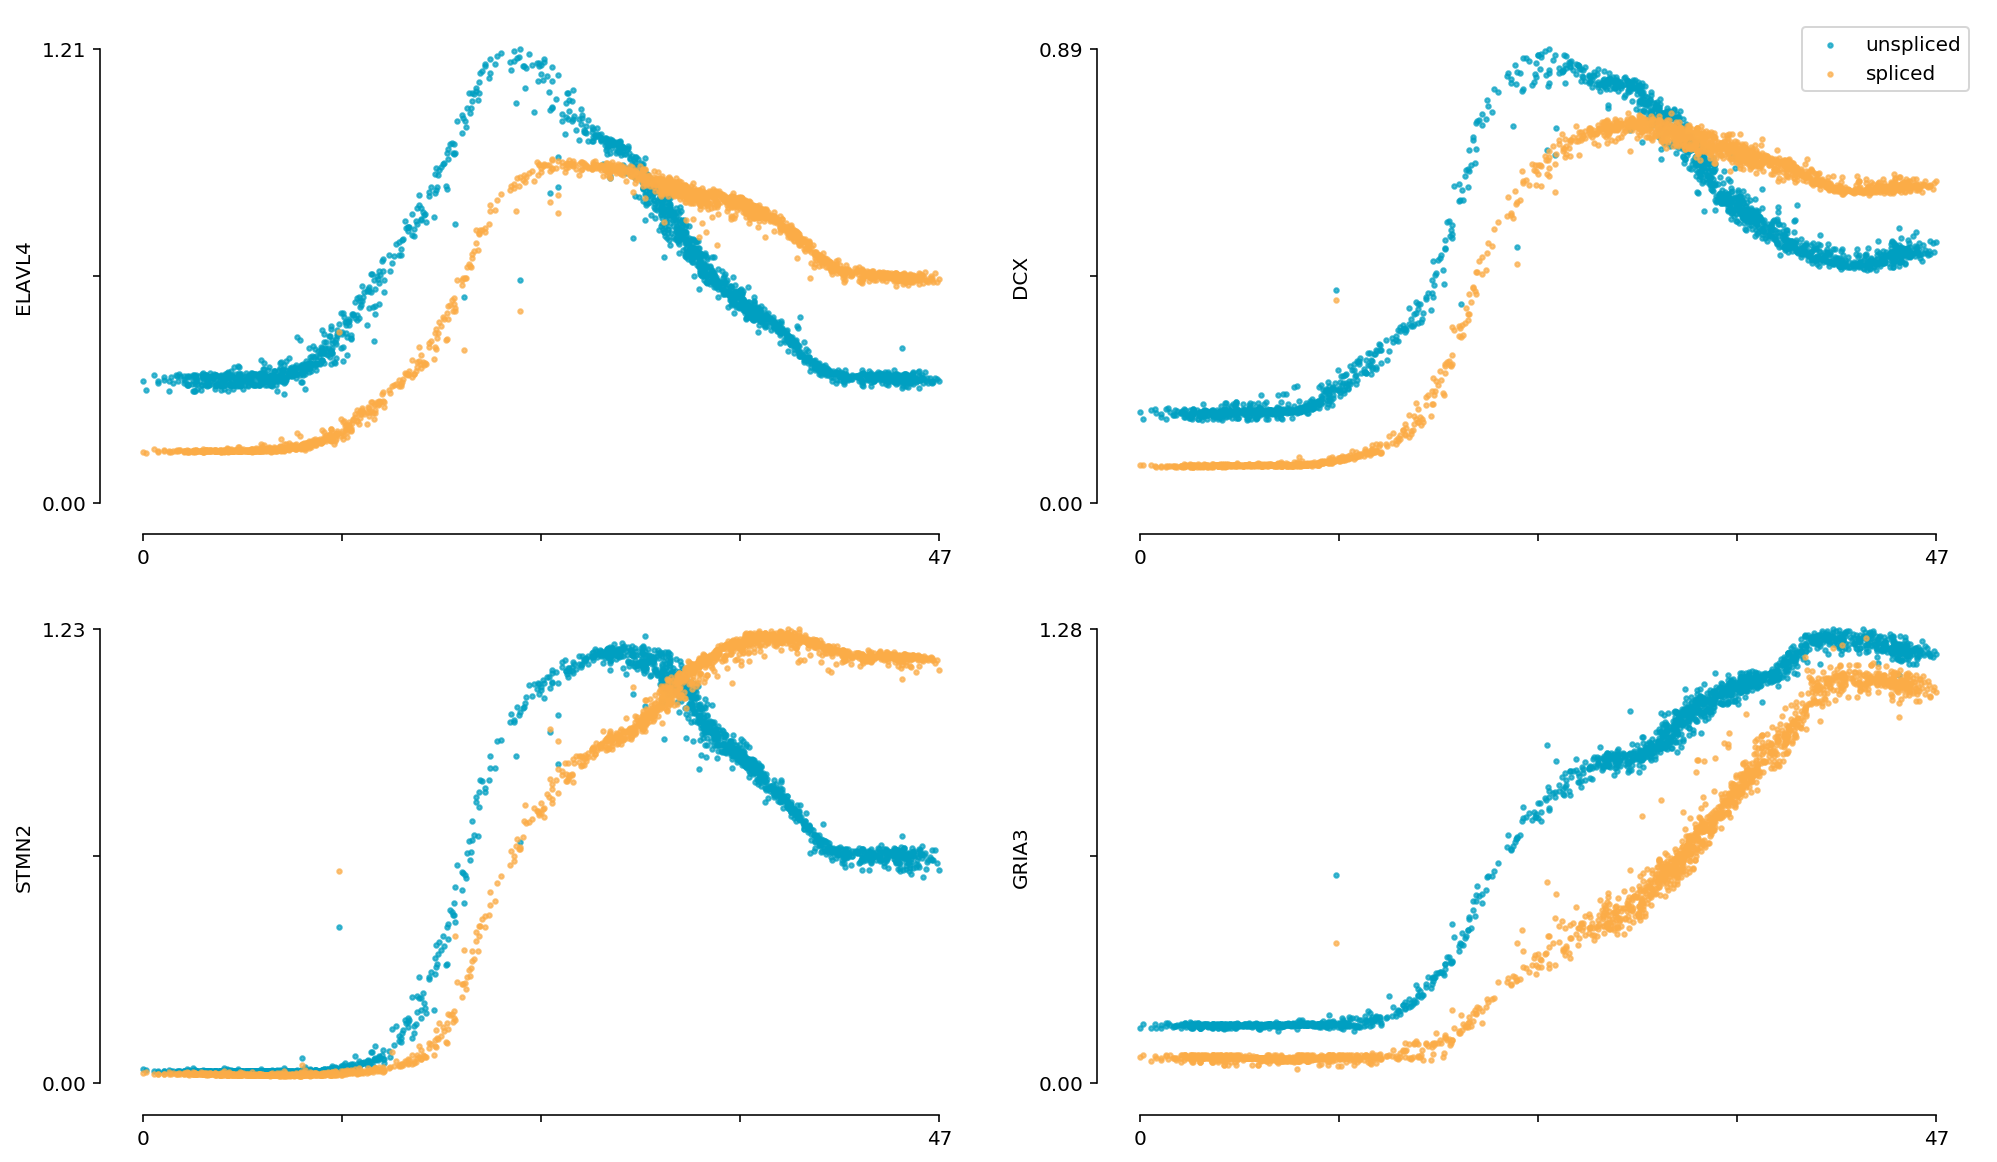

In [94]:
#peek_shown = ["FAM64A", "RNASEH2B", "ELAVL4", "DCX", "STMN2", "GRIA3"]
peek_shown = old
plt.figure(None, (14,12.))
gs = plt.GridSpec(3,2)
for n, gene in enumerate(peek_shown[2::]):
    i = np.where(vlm.ra["var_names"] == gene)
    ax = plt.subplot(gs[n])
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], vlm.Ux_sz[i, pc_obj.ixsort],
                alpha=0.7, c=np.array([0,159,193])/255, s=5, label="unspliced")
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], vlm.Sx_sz[i, pc_obj.ixsort]*vlm.gammas[i],
                alpha=0.7, c=np.array([251, 172, 71])/255, s=5, label="spliced")
    m = 0 #np.minimum(np.min(vlm.Ux_sz[i,:]), np.min(vlm.Sx_sz[i,:]*vlm.gammas[i]))
    M = np.maximum(np.max(vlm.Ux_sz[i,:]), np.max(vlm.Sx_sz[i,:]*vlm.gammas[i]))
    plt.ylim(m - 0.07*(M-m), M + 0.07*(M-m))
    plt.ylabel(gene)
    plt.yticks([m,0.5*(m+M),M], [f"{m:.2f}", "", f"{M:.2f}"])
    p = np.min(pc_obj.arclength[pc_obj.ixsort])
    P = np.max(pc_obj.arclength[pc_obj.ixsort])
    plt.xticks(np.linspace(p,P,5), [f"{p:.0f}", "","","", f"{P:.0f}"])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_bounds(m, M)
    ax.spines['bottom'].set_bounds(p, P)
    if n == 1:
        plt.legend()
plt.tight_layout()